In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from concurrent.futures import ProcessPoolExecutor

In [3]:
# Define the model itself

# Define a structured array type for parameters
param_dtype = np.dtype([
    ('beta0', np.float64),
    ('beta_amp', np.float64),
    ('freq', np.float64),
    ('phase', np.float64),
    ('gamma', np.float64),
    ('waning_rate', np.float64),
    ('birth_rate', np.float64),
    ('death_rate', np.float64),
    ('noise_level', np.float64)
])

@njit
def is_close_to_multiple(number, multiple, tolerance):
  """
  Checks if a number is close to a multiple of another number.

  Args:
    number: The number to check.
    multiple: The multiple to check against.
    tolerance: The allowed deviation from a perfect multiple.

  Returns:
    True if the number is close to a multiple, False otherwise.
  """

  remainder = number % multiple
  return remainder <= tolerance or remainder >= multiple - tolerance

@njit
def run_simulation(t, params, S0, I0, strobe=7):
    
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))
    S[0], I[0], R[0] = S0, I0, 1 - S0 - I0

    dt = t[1]-t[0]
    
    gamma = params.gamma
    mu = params.birth_rate
    delta = params.waning_rate
    noise_level = params.noise_level

    if noise_level > 0:
        alpha = dt/noise_level**2
        beta = noise_level**2
        k_shape = alpha
        theta_scale = beta
    
    for i in range(1,len(t)):
        beta = params.beta0 * (1 + params.beta_amp * np.sin(2 * np.pi * params.freq * t[i] + params.phase))
        if noise_level > 0:
            DeltaGamma_loc = np.random.gamma(k_shape, theta_scale)
            noise = DeltaGamma_loc/dt
        else:
            noise = 1.0
        beta = beta * noise
        foi = beta * I[i-1]
        Sout = (1 - np.exp(-(foi + mu)*dt)) * S[i - 1]
        StoI = foi / (foi + mu) * Sout
        Iout = (1 - np.exp(-(gamma + mu)*dt)) * I[i - 1]
        ItoR = gamma / (gamma + mu) * Iout
        Rout = (1 - np.exp(-(delta + mu)*dt)) * R[i - 1]
        RtoS = Rout * delta/(delta + mu);
        #RtoS = 0
        S[i] = S[i - 1] - Sout + mu*dt + RtoS
        I[i] = I[i - 1] + StoI - Iout
        R[i] = R[i - 1] + ItoR - Rout
    
    return t[::strobe], I[::strobe], S[::strobe]

In [4]:
# Simulation setup
n_years = 1100

time_steps_per = 4
#time_steps_per = 14
#time_steps_per = 28
#time_steps_per = 56

nth = time_steps_per
t = np.linspace(0, 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time

# Create a structured array for parameters
params = np.zeros(1, dtype=param_dtype)[0]
params['beta_amp'] = 0.18569449
params['freq'] = 1/52
params['phase'] = 3.5983933
#params['gamma'] = 1/21
#params['gamma'] = 1/2
#params['gamma'] = 1/2.5 # gamma=2.5, beta0=3*gamma is interesting!
params['gamma'] = 1/2.5
#params['beta0'] = 1
params['beta0'] = 0.713929532
#params['beta0'] = 10/21
params['waning_rate'] = 0.0017271
params['birth_rate'] = 1/(80*52)
params['death_rate'] = 1/(80*52)
params['noise_level'] = 0.0

In [8]:
# Function to compute peak periods for a given beta0
def compute_peak_periods(t, I, transient_years=900):
    from scipy.signal import periodogram
    """
    t and I must be numpy arrays
    """

    mask_post_transient = t > transient_years * 52
    
    peak_periods_list = []
    powers_list = []

    # Remove transients
    incidences = I[mask_post_transient]
    t = t[mask_post_transient]
    dt = t[2]-t[1]

    # Compute periodogram
    frequencies, power = periodogram(incidences, fs=dt)
    periods = np.where(frequencies > 0, 1 / (frequencies + 1e-30), np.inf) / 52  # Convert to years

    # Filter to periods ≤ 10 years
    valid_indices = periods <= 10
    filtered_periods = periods[valid_indices]
    filtered_power = power[valid_indices]

    # Identify the most prominent peak
    if len(filtered_power) > 0:
        sortidx = np.argsort(filtered_power)[::-1]
        filtered_power = filtered_power[sortidx]
        filtered_periods = filtered_periods[sortidx]
        for i in range(0,3):
            peak_periods_list.append(filtered_periods[i])
            powers_list.append(filtered_power[i])

    return np.array(peak_periods_list), np.array(powers_list)

def close_to(x, y, tol=0.1):
    if x-tol < y and x+tol > y:
        return True
    else:
        return False

In [40]:
def weeks_from_tseries(tseries, params):
    t_lowest_transmission = (-np.pi/2 - params['phase'])/(2 * np.pi * params['freq'])
    week_lowest_transmission = 10
    weekseries = (tseries + week_lowest_transmission - t_lowest_transmission) % 52
    return weekseries

# Fig 4C

In [5]:
# That clearly worked, now we need to do this at all sorts of different times and do some Fourier analysis as well
# First, determine a good starting point for the simulation.
# In other words, compute the first 1000 years of the deterministic model
# and then take that as the starting point for all of the perturbations
from copy import deepcopy 

t = np.linspace(0, 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time

# Create a structured array for parameters
params = np.zeros(1, dtype=param_dtype)[0]
params['beta_amp'] = 0.18569449
params['freq'] = 1/52
params['phase'] = 0
#params['gamma'] = 1/21
#params['gamma'] = 1/2
#params['gamma'] = 1/2.5 # gamma=2.5, beta0=3*gamma is interesting!
params['gamma'] = 1/2.5
#params['beta0'] = 1
params['beta0'] = 0.713929532
#params['beta0'] = 10/21
params['waning_rate'] = 0.0017271
params['birth_rate'] = 1/(80*52)
params['death_rate'] = 1/(80*52)
params['noise_level'] = 0.0

t_out, I, S = run_simulation(t, params, 0.5, 1e-4, strobe=time_steps_per) # run_simulation(t, params, S0, I0, strobe=strobe)

# Experiment to see if we can continue the simulation for e.g. another n1 < 1.0 years, then perturb, and then another n2 > 10 years:
start_times = np.arange(t[1], 52+t[1], 1.0/7.0)
I_trajectories = []
S_trajectories = []
I_devi_trajectories = []
S_devi_trajectories = []
full_traj_times = []
devi_traj_times = []

for i, n1_weeks in enumerate(start_times):
    t0 = t_out[-1]
    t1 = np.linspace(t0, t0 + n1_weeks, int(np.round(n1_weeks * time_steps_per)))
    
    #print(f"t : {n1_weeks}, intermediate timesteps: {len(t1)}")
    
    params1 = deepcopy(params)
    t_out1, I1, S1 = run_simulation(t1, params1, S[-1], I[-1], strobe=time_steps_per)
    # Then a perturbation:
    #dI = 0.1 * I1[-1]
    #dI = 1.0 * I1[-1]
    dI = -0.8 * I1[-1]
    I2_0 = I1[-1] + dI
    #S2_0 = S1[-1] - dI
    S2_0 = S1[-1]
    # Resume simulation:
    n2_years = 10.0
    #t0 = t1[-1] - time_steps_per*t1[1]
    t0 = t_out1[-1]
    t2 = np.linspace(t0, t0 + 52 * n2_years, int(np.round(52 * n2_years * time_steps_per)))
    params2 = deepcopy(params)
    t_out2, I2, S2 = run_simulation(t2, params2, S2_0, I2_0, strobe=time_steps_per)
    full_traj_times.append(list(t_out[:-1]) + list(t_out1[:-1]) + list(t_out2))
    devi_traj_times.append(list(t_out2))
    I_trajectories.append(list(I[:-1]) + list(I1[:-1]) + list(I2))
    S_trajectories.append(list(S[:-1]) + list(S1[:-1]) + list(S2))
    I_devi_trajectories.append(I2)
    S_devi_trajectories.append(S2)

Sim 14 had periods [4.99759615 0.99951923 2.49879808] with power [1.         0.54370836 0.12149423]


[Text(1, 0.0, '22'),
 Text(1, 0.25, '35'),
 Text(1, 0.5, '48'),
 Text(1, 0.75, '9'),
 Text(1, 1.0, '21')]

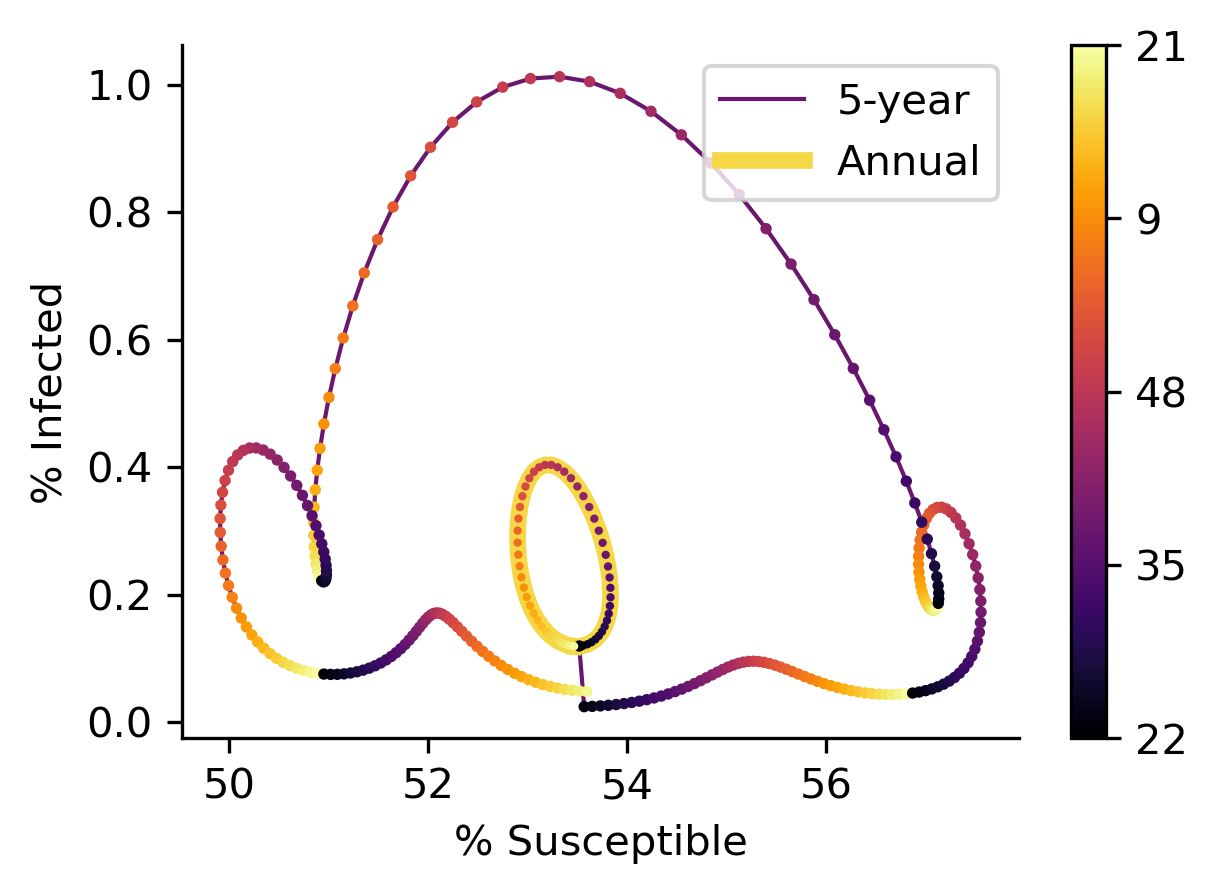

In [39]:
import matplotlib.cm as cm

n_shown = 0

to_show = 10

fig = plt.figure(figsize=(4.5, 3), dpi=300)

#for i in range(len(S_trajectories)):
for i in [14]:
    t_loc = np.array(devi_traj_times[i])
    I_loc = np.array(I_devi_trajectories[i])
    ppl, ppp = compute_peak_periods(t_loc, I_loc, transient_years=0)
    ppp = ppp/np.max(ppp)

    #I_plot = np.array(I_trajectories[i])[-2*len(t_loc):]
    #S_plot = np.array(S_trajectories[i])[-2*len(t_loc):]
    I_plot = np.array(I_trajectories[i])[-len(t_loc)-1:] * 100
    S_plot = np.array(S_trajectories[i])[-len(t_loc)-1:] * 100

    #I_plot = np.array(I_devi_trajectories[i])[:10]
    #S_plot = np.array(S_devi_trajectories[i])[:10]
    
    #print(f"Sim {i} had periods {ppl} with power {ppp}")
    if close_to(ppl[0], 5) or (ppp[1] > 0.78 and close_to(ppl[1], 5)):
        print(f"Sim {i} had periods {ppl} with power {ppp}")
        if n_shown < to_show:
            #plt.plot(S_plot, I_plot, "--", alpha=1, linewidth=2, label=f"{i},  {start_times[i]}")
            #plt.plot(S_plot, I_plot, alpha=1, linewidth=2, label=f"Transient 5-year cycle", color=plt.cm.inferno(0.3))

            t_loc = [t_loc[0] - 1] + list(t_loc)
            t_loc = np.array(t_loc)
            
            max_plot_index = int(len(t_loc)/2)-1
            
            plt.plot(S_plot[:max_plot_index], I_plot[:max_plot_index], alpha=1, linewidth=1, label=f"5-year", color=plt.cm.inferno(0.3), zorder=1)
            
            
            #scatter_colors = plt.cm.inferno(np.linspace(0, 1, len(S_plot)))
            #scatter_colors = plt.cm.inferno( 0.5 * (np.sin(2 * np.pi * t_loc/52) + 1) )
            scatter_colors = plt.cm.inferno((t_loc % 52)/52)[:max_plot_index]

            
            plt.scatter(S_plot[:max_plot_index], I_plot[:max_plot_index], alpha=1, s=3, color=scatter_colors, zorder=2)
            n_shown += 1


#plt.plot(S[-53:], I[-53:], color=plt.cm.inferno(0.90), label="Annual cycle", alpha=1, linewidth=3.8)
plt.plot(S[-53:]*100, I[-53:]*100, color=plt.cm.inferno(0.90), label="Annual", alpha=1, linewidth=4,  zorder=1)
t_loc_annual = t_out[-53:]
scatter_colors = plt.cm.inferno((t_loc_annual % 52)/52)
plt.scatter(S[-53:]*100, I[-53:]*100, color=scatter_colors, alpha=1, s=1, zorder=2)
plt.legend(loc='upper right')

plt.xlabel("% Susceptible")
plt.ylabel("% Infected")

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

cbar = fig.colorbar(cm.ScalarMappable(cmap=plt.cm.inferno ), ax=ax, ticks=[0,0.25, 0.5, 0.75, 1])
weekseries = weeks_from_tseries(t_loc_annual, params)

w0 = round(weekseries[0])
cbarticklabels = []
nticks = 5
for i in range(nticks):
    cbarticklabels.append(round(weekseries[0] + i * 52/(nticks-1)) % 52) 
cbarticklabels[-1] -= 1
cbar.ax.set_yticklabels(cbarticklabels)  

# Fig 4A:

In [73]:
# Let us do a (time of year, magnitude of perturbation) heatmap!

# That clearly worked, now we need to do this at all sorts of different times and do some Fourier analysis as well
# First, determine a good starting point for the simulation.
# In other words, compute the first 1000 years of the deterministic model
# and then take that as the starting point for all of the perturbations

#t = np.linspace(52-weeks_from_tseries(0, params), 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time
t = np.linspace(weeks_from_tseries(0, params), 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time

t_out, I, S = run_simulation(t, params, 0.5, 1e-4, strobe=time_steps_per) # run_simulation(t, params, S0, I0, strobe=strobe)

I_late = I[-52*time_steps_per*100:]
eps_I = 1e-18

# Experiment to see if we can continue the simulation for e.g. another n1 < 1.0 years, then perturb, and then another n2 > 10 years:
start_times = np.arange(t[1], 52+t[1], 1.0/7.0)
# Rearrange start time according to week numbers:
start_weeks = weeks_from_tseries(start_times, params)
sortidx = np.argsort(start_weeks)
start_times = start_times[sortidx]
start_weeks = start_weeks[sortidx]

five_powers = []
dIs = np.linspace(-0.99*np.min(I_late), 2*0.99*np.min(I_late), 300)

five_powers_mat = np.zeros((len(dIs), len(start_times)))
dI_mat = np.zeros((len(dIs), len(start_times)))
t_mat = np.zeros((len(dIs), len(start_times)))

m_i = 0

for dI in dIs:
    m_j = 0
    for i, n1_weeks in enumerate(start_times):
        t0 = t_out[-1]
        t1 = np.linspace(t0, t0 + n1_weeks, int(np.round(n1_weeks * time_steps_per)))
        
        #print(f"t : {n1_weeks}, intermediate timesteps: {len(t1)}")
        
        params1 = deepcopy(params)
        t_out1, I1, S1 = run_simulation(t1, params1, S[-1], I[-1], strobe=time_steps_per)
        # Then a perturbation:
        I2_0 = max(I1[-1] + dI, eps_I)
        S2_0 = S1[-1]
        # Resume simulation:
        n2_years = 10.0
        #t0 = t1[-1] - time_steps_per*t1[1]
        t0 = t_out1[-1]
        t2 = np.linspace(t0, t0 + 52 * n2_years, int(np.round(52 * n2_years * time_steps_per)))
        params2 = deepcopy(params)
        t_out2, I2, S2 = run_simulation(t2, params2, S2_0, I2_0, strobe=time_steps_per)
        ppl, ppp = compute_peak_periods(t_out2, I2, transient_years=0)
        ppp = ppp/np.max(ppp)
        five_power = 0.0
        one_power = 0.5
        for j in range(len(ppl)):
            if close_to(ppl[j], 5, tol=0.1):
                five_power = ppp[j]
        #if close_to(ppl[0], 5, tol=0.1):
        #    five_power /= ppp[1]
        five_powers.append(five_power)
        five_powers_mat[m_i, m_j] = five_power
        dI_mat[m_i, m_j] = dI
        t_mat[m_i, m_j] = weeks_from_tseries(t0, params)
        #print(f"Week: {t_mat[m_i, m_j]}")
        m_j += 1
    m_i += 1

/tmp/ipykernel_399826/2943682538.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  heatmap = plt.pcolormesh(t_mat, dI_mat, five_powers_mat, shading='nearest', cmap='inferno')


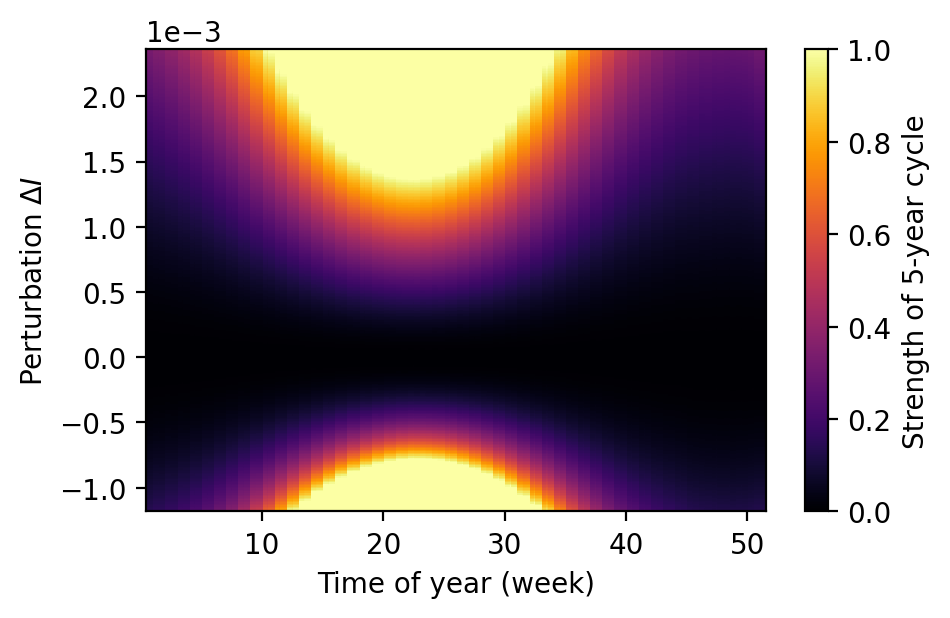

In [74]:

# Create the heatmap
plt.figure(figsize=(5, 3), dpi=200)
#heatmap = plt.pcolormesh(t_mat, dI_mat, np.log(five_powers_mat+0.01), shading='nearest', cmap='inferno')
heatmap = plt.pcolormesh(t_mat, dI_mat, five_powers_mat, shading='nearest', cmap='inferno')

ax = plt.gca()

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label("Strength of 5-year cycle")

# Label axes
plt.xlabel("Time of year (week)")
plt.ylabel(r"Perturbation $\Delta I$")

ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
#ax.ticklabel_format(style='sci', axis='y')

# Show the heatmap
plt.show()


# Fig 4B

In [70]:
# Let us do a (time of year, magnitude of perturbation) heatmap!

# That clearly worked, now we need to do this at all sorts of different times and do some Fourier analysis as well
# First, determine a good starting point for the simulation.
# In other words, compute the first 1000 years of the deterministic model
# and then take that as the starting point for all of the perturbations
from copy import deepcopy 

t = np.linspace(weeks_from_tseries(0, params), 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time

t_out, I, S = run_simulation(t, params, 0.5, 1e-4, strobe=time_steps_per) # run_simulation(t, params, S0, I0, strobe=strobe)

# Experiment to see if we can continue the simulation for e.g. another n1 < 1.0 years, then perturb, and then another n2 > 10 years:
start_times = np.arange(t[1], 52+t[1], 1.0/7.0)
# Rearrange start time according to week numbers:
start_weeks = weeks_from_tseries(start_times, params)
sortidx = np.argsort(start_weeks)
start_times = start_times[sortidx]
start_weeks = start_weeks[sortidx]

five_powers = []
dI_multipliers = np.arange(-0.99, 1.0, 0.01)

five_powers_mat = np.zeros((len(dI_multipliers), len(start_times)))
dI_mat = np.zeros((len(dI_multipliers), len(start_times)))
t_mat = np.zeros((len(dI_multipliers), len(start_times)))

m_i = 0

for dI_multiplier in dI_multipliers:
    m_j = 0
    for i, n1_weeks in enumerate(start_times):
        t0 = t_out[-1]
        t1 = np.linspace(t0, t0 + n1_weeks, int(np.round(n1_weeks * time_steps_per)))
        
        #print(f"t : {n1_weeks}, intermediate timesteps: {len(t1)}")
        
        params1 = deepcopy(params)
        t_out1, I1, S1 = run_simulation(t1, params1, S[-1], I[-1], strobe=time_steps_per)
        # Then a perturbation:
        #dI = 0.1 * I1[-1]
        dI = dI_multiplier * I1[-1]
        #dI = -0.2 * I1[-1]
        I2_0 = I1[-1] + dI
        #S2_0 = S1[-1] - dI
        S2_0 = S1[-1]
        # Resume simulation:
        n2_years = 10.0
        #t0 = t1[-1] - time_steps_per*t1[1]
        t0 = t_out1[-1]
        t2 = np.linspace(t0, t0 + 52 * n2_years, int(np.round(52 * n2_years * time_steps_per)))
        params2 = deepcopy(params)
        t_out2, I2, S2 = run_simulation(t2, params2, S2_0, I2_0, strobe=time_steps_per)
        ppl, ppp = compute_peak_periods(t_out2, I2, transient_years=0)
        ppp = ppp/np.max(ppp)
        five_power = 0.0
        one_power = 0.5
        for j in range(len(ppl)):
            if close_to(ppl[j], 5, tol=0.1):
                five_power = ppp[j]
        #if close_to(ppl[0], 5, tol=0.1):
        #    five_power /= ppp[1]
        five_powers.append(five_power)
        five_powers_mat[m_i, m_j] = five_power
        dI_mat[m_i, m_j] = dI_multiplier
        t_mat[m_i, m_j] = weeks_from_tseries(t0, params)
        m_j += 1
    m_i += 1

/tmp/ipykernel_399826/1442210022.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  heatmap = plt.pcolormesh(t_mat, dI_mat, five_powers_mat, shading='nearest', cmap='inferno')


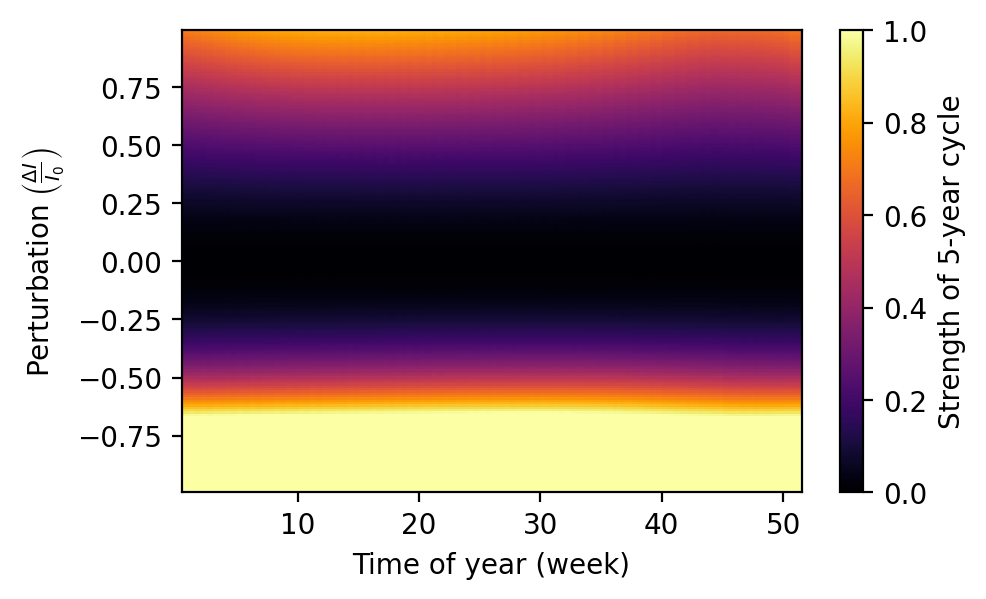

In [72]:

# Create the heatmap
plt.figure(figsize=(5, 3), dpi=200)
#heatmap = plt.pcolormesh(t_mat, dI_mat, np.log(five_powers_mat+0.01), shading='nearest', cmap='inferno')
heatmap = plt.pcolormesh(t_mat, dI_mat, five_powers_mat, shading='nearest', cmap='inferno')

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label("Strength of 5-year cycle")

# Label axes
plt.xlabel("Time of year (week)")
plt.ylabel(r"Perturbation $\left(\frac{\Delta I}{I_0}\right)$")

# Show the heatmap
plt.show()


# Fig 4D

In [67]:
# Let us do a (time of year, magnitude of perturbation) heatmap!

# That clearly worked, now we need to do this at all sorts of different times and do some Fourier analysis as well
# First, determine a good starting point for the simulation.
# In other words, compute the first 1000 years of the deterministic model
# and then take that as the starting point for all of the perturbations

t = np.linspace(weeks_from_tseries(0, params), 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time

t_out, I, S = run_simulation(t, params, 0.5, 1e-4, strobe=time_steps_per) # run_simulation(t, params, S0, I0, strobe=strobe)

I_late = I[-52*time_steps_per*100:]
eps_I = 1e-18

# Experiment to see if we can continue the simulation for e.g. another n1 < 1.0 years, then perturb, and then another n2 > 10 years:
start_times = np.arange(t[1], 52+t[1], 1.0/7.0)
# Rearrange start time according to week numbers:
start_weeks = weeks_from_tseries(start_times, params)
sortidx = np.argsort(start_weeks)
start_times = start_times[sortidx]
start_weeks = start_weeks[sortidx]

five_powers = []
dSs = np.linspace(-0.05, 0.05, 300)

five_powers_mat = np.zeros((len(dSs), len(start_times)))
dS_mat = np.zeros((len(dSs), len(start_times)))
t_mat = np.zeros((len(dSs), len(start_times)))

m_i = 0

for dS in dSs:
    m_j = 0
    for i, n1_weeks in enumerate(start_times):
        t0 = t_out[-1]
        t1 = np.linspace(t0, t0 + n1_weeks, int(np.round(n1_weeks * time_steps_per)))
        
        #print(f"t : {n1_weeks}, intermediate timesteps: {len(t1)}")
        
        params1 = deepcopy(params)
        t_out1, I1, S1 = run_simulation(t1, params1, S[-1], I[-1], strobe=time_steps_per)
        # Then a perturbation:
        I2_0 = I1[-1]
        S2_0 = S1[-1] + dS
        # Resume simulation:
        n2_years = 10.0
        #t0 = t1[-1] - time_steps_per*t1[1]
        t0 = t_out1[-1]
        t2 = np.linspace(t0, t0 + 52 * n2_years, int(np.round(52 * n2_years * time_steps_per)))
        params2 = deepcopy(params)
        t_out2, I2, S2 = run_simulation(t2, params2, S2_0, I2_0, strobe=time_steps_per)
        ppl, ppp = compute_peak_periods(t_out2, I2, transient_years=0)
        ppp = ppp/np.max(ppp)
        five_power = 0.0
        one_power = 0.5
        for j in range(len(ppl)):
            if close_to(ppl[j], 5, tol=0.1):
                five_power = ppp[j]
        #if close_to(ppl[0], 5, tol=0.1):
        #    five_power /= ppp[1]
        five_powers.append(five_power)
        five_powers_mat[m_i, m_j] = five_power
        dS_mat[m_i, m_j] = dS
        t_mat[m_i, m_j] = weeks_from_tseries(t0, params)
        m_j += 1
    m_i += 1

/tmp/ipykernel_399826/2573639693.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  heatmap = plt.pcolormesh(t_mat, dS_mat, five_powers_mat, shading='nearest', cmap='inferno')


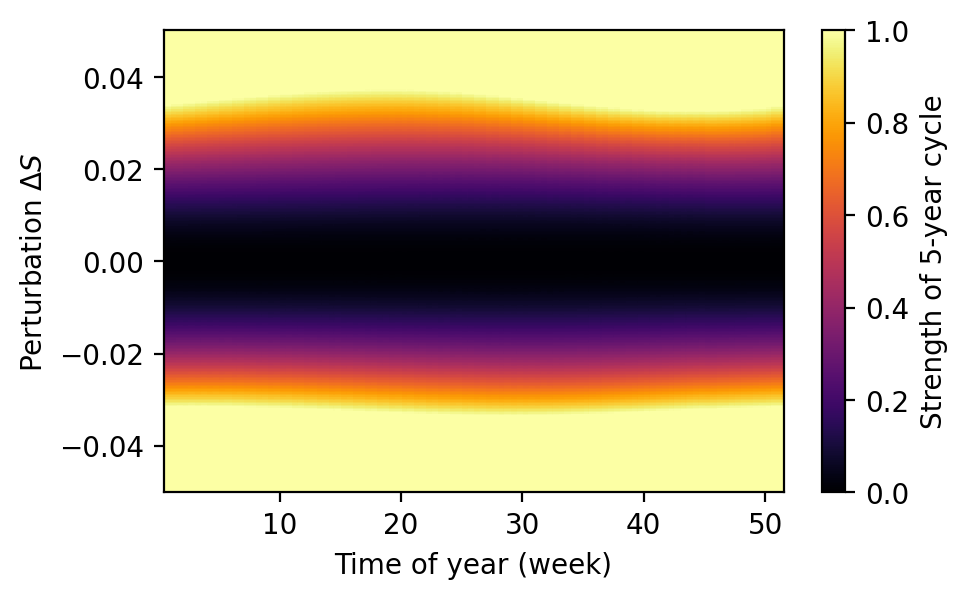

In [68]:
# Create the heatmap
plt.figure(figsize=(5, 3), dpi=200)
heatmap = plt.pcolormesh(t_mat, dS_mat, five_powers_mat, shading='nearest', cmap='inferno')

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label("Strength of 5-year cycle")

# Label axes
plt.xlabel("Time of year (week)")
plt.ylabel(r"Perturbation $\Delta S$")

# Show the heatmap
plt.show()
